# How to Write a Flash Attention Kernel in Pallas
## Introduction

In the previous posts in this series, we learnt how to write a [matrix multiplication kernel](https://blog.vikrampawar.com/pallas-matmul.html) and a [softmax kernel](https://blog.vikrampawar.com/pallas-softmax.html) using Pallas. Building on these, we will design a fused self-attention kernel. Self-attention is a major bottleneck in deep learning architectures. In a naive implementation, materializing the full N×N attention matrix requires O(N²) memory bandwidth. This creates a severe bottleneck on GPUs, as the time to transfer this data from high-bandwidth memory (HBM) dominates over the actual computation time.

## Self Attention

Mathematically, the self-attention operation is `softmax(QK^T / √d) @ V`, where Q is a set of queries, K is a set of keys and V is a set of values.

The Queries (Q) are usually a tensor of shape `(B, H, T, D)`, where `B` is batch size, `H` is number of heads, `T` is sequence length, and `D` is the embedding dimension (or head dimension). Each query vector represents a position in the sequence that attends to keys. Keys are used to compute attention scores with queries while values are the information retrieved based on attention weights.
Scaling by $1/\sqrt{d}$ stabilizes the variance, ensuring the softmax behaves similarly across different embedding dimensions, improving optimization and generalization.

To understand the basics of self-attention in more detail, [here's](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html) an excellent blogpost by Sebastian Raschka.




## Minimal GPU System Architecture

To test our implementation, we will use an NVIDIA RTX 4000 Ada Generation GPU. This is fairly powerful (and cheap!) modern GPU architecture. Let's build a simple model of its system architecture. This will help us understand compute and memory tradeoffs involved.

![rtx-sys-diag](rtx_4000_ada_system_diagram.png)

### Key Specifications

The RTX 4000 Ada has 20 GB of high-bandwidth memory (HBM) with 360 GB/s bandwidth. This stores all our input and output tensors (Q, K, V, O, gradients). Each streaming multiprocessor (SM) has 128 KB of shared memory (SMEM/L1 cache) with ~10-30 TB/s bandwidth—this is where we'll store our tiles. The GPU's tensor cores deliver 106.9 TFLOP/s peak compute for bfloat16 operations. There's also a 48 MB L2 cache shared across all SMs, but it's hardware-managed and not directly accessible from Pallas kernels.

### Memory Hierarchy

SMEM/L1 cache (128 KB per SM) is the fastest memory. At ~10-30 TB/s bandwidth, it's orders of magnitude faster than HBM. Crucially, it's software-managed—we explicitly control what gets loaded and stored via `plgpu.load` and `plgpu.store` in our Pallas kernels. Each SM has its own 128 KB, isolated from others. This is where flash attention keeps intermediate tiles, attention score tiles, and accumulators. 

L2 cache (48 MB) sits in the middle. However, it's hardware-managed—we can't directly access it from Pallas kernels. All SMs compete for this shared space, and hardware may evict data between operations. The kernel design assumes data lives in SMEM or HBM only.

HBM (20 GB) is the slowest memory at 360 GB/s, but it has the largest capacity. This stores all our tensors, Q, K, V inputs, O outputs, and gradients dQ, dK, dV. Every read or write to HBM costs execution time, so minimizing HBM transfers is critical for performance. Flash attention reads Q, K, V from HBM once and writes O to HBM once—everything else stays in SMEM.


## Naive Self-Attention

In [27]:
import jax
import jax.numpy as jnp

@jax.jit
def naive_attention(q, k, v):
    d = q.shape[-1]
    logits = jnp.einsum('bhqd,bhkd->bhqk', q, k) / jnp.sqrt(d)
    probs = jax.nn.softmax(logits, axis=-1)
    o = jnp.einsum('bhqk,bhkd->bhqd', probs, v)
    return o

B, H, T, C = 2, 4, 256, 64
key = jax.random.key(0)
keys = jax.random.split(key, 4)

# Use bfloat16 for optimal performance
q = jax.random.normal(keys[0], (B, H, T, C), dtype=jnp.bfloat16)
k = jax.random.normal(keys[1], (B, H, T, C), dtype=jnp.bfloat16)
v = jax.random.normal(keys[2], (B, H, T, C), dtype=jnp.bfloat16)
do = jax.random.normal(keys[3], (B, H, T, C), dtype=jnp.bfloat16)

# Forward check
o_ref = naive_attention(q, k, v)
print(f"Reference output shape: {o_ref.shape}")

# Backward check
def loss_ref(q, k, v):
    return jnp.sum(naive_attention(q, k, v) * do)

dq_ref, dk_ref, dv_ref = jax.grad(loss_ref, argnums=(0, 1, 2))(q, k, v)
print(f"Reference gradient shapes: dq={dq_ref.shape}, dk={dk_ref.shape}, dv={dv_ref.shape}")



Reference output shape: (2, 4, 256, 64)
Reference gradient shapes: dq=(2, 4, 256, 64), dk=(2, 4, 256, 64), dv=(2, 4, 256, 64)


### Why it is Slow

The naive implementation must handle a T×T attention matrix that quickly exceeds GPU shared memory (SMEM) capacity.

| T | T×T matrix (bf16) | Fits in SMEM? |
|---|------------------|---------------|
| 128 | 32KB |  Yes (barely) |
| 256 | 128KB |  No |

For T≥256, the attention matrix must be materialized in HBM. Here's the actual data flow:

1. Read Q, K, V from HBM
2. Compute Q @ K^T in tiles (each tile fits in SMEM), write each tile to HBM as it completes
3. Read the T×T matrix from HBM row-by-row for softmax: first pass computes row max, second pass computes exp(x - max), sum, and normalizes
4. Write softmax output to HBM
5. Read softmax output from HBM for P @ V (tiled)
6. Write final output O to HBM

The matmuls use tiling internally—small blocks are loaded into SMEM, computed, and written back—but the full T×T result must still be materialized in HBM between operations. 

Softmax processes one row at a time (T elements easily fit in SMEM), but requires two passes through each row: once to find the maximum value, and again to compute the normalized probabilities. This means the T×T matrix is read twice during the softmax operation alone.

## Flash Attention Algorithm (Forward Pass)

The key insight is that we can compute the attention output without ever materializing the full T×T attention matrix in HBM. Instead, we process it in small tiles that fit in SMEM, discarding each tile after using it. 

**Flash attention data flow:**
- Load Q tile, K tile, V tile into SMEM
- Compute Q @ K^T → T×T tile in SMEM
- Compute online softmax on the tile (using running statistics)
- Multiply with V and accumulate into output in SMEM
- Repeat for all K/V tiles, accumulating into same output
- Write final output (T×D) to HBM once

**Algorithm steps:**
- Tile Q (outer parallel loop)
- Tile K, V (inner sequential loop)
- Maintain running max `m`, sum `l`, and output accumulator `o`
- Correction factor when max changes (online softmax)
- Final normalization

Check out the [Pallas softmax kernel implementation](https://blog.vikrampawar.com/pallas-softmax.html) to understand the online softmax algorithm.

### The Logsumexp Trick

The logsumexp trick is what enables the flash attention backward pass to avoid recomputing the softmax statistics. During the forward pass, we compute and store logsumexp values alongside the output. 

Starting from the softmax definition:

$$
P_i = \frac{\exp(S_i - m)}{\sum_j \exp(S_j - m)} \\

\log P_i = \log \exp(S_i - m) - \log \left( \sum_j \exp(S_j - m) \right) \\

\log P_i = S_i - m - \log \left( \sum_j \exp(S_j - m) \right) \\
$$

Let $l = \sum_j \exp(S_j - m)$. Then:

$$
\log P_i = S_i - m - \log l \\

\log P_i = S_i - (m + \log l) \\

\text{logsumexp} = m + \log l \\
$$

Substituting back:

$$
\log P_i = S_i - \text{logsumexp} \\
P_i = \exp(S_i - \text{logsumexp})
$$

### Choosing Kernel and Embedding Size

The flash attention kernel in this implementation uses hardcoded block sizes (BLOCK_R, BLOCK_C). 
Let's calculate the shared memory usage for the forward pass kernel. The following tensors reside in shared memory:

For C=64:
- q_reg: $64 \times 64 \times 2$ = 8KB
- k_blk: $64 \times 64 \times 2$ = 8KB
- v_blk: $64 \times 64 \times 2$ = 8KB
- o_reg: $64 \times 64 \times 4$ = 16KB
- s_blk: $64 \times 64 \times 4$ = 16KB
- max_reg, l_reg, max_blk, l_blk, logsumexp_reg: $5 \times 64 \times 4$ = 1.25KB

Subtotal: ~57KB

With NUM_STAGES=2, software pipelining allocates additional copies of k_blk and v_blk to overlap memory loads with computation, adding ~16KB.

Total for C=64: ~73KB + compiler overhead

For C=128:
- q_reg, k_blk, v_blk: $3 \times 64 \times 128 \times 2$ = 48KB
- o_reg: $64 \times 128 \times 4$ = 32KB
- s_blk: $64 \times 64 \times 4$ = 16KB
- Scalar registers: ~1.25KB
- Pipelining overhead: ~32KB

Total for C=128: ~129KB — exceeds the 99KB limit

Our GPU allows up to 99KB of SMEM. With the mixed-precision strategy and software pipelining overhead, C=64 fits comfortably while C=128 exceeds the limit.

In [28]:
BLOCK_R = 64  # Block size for rows (Q blocks)
BLOCK_C = 64  # Block size for columns (KV blocks)
INTERPRET_MODE = False  # Set True for CPU debugging, False for GPU execution

In [29]:
from functools import partial
import math

from jax.experimental import pallas as pl
from jax.experimental.pallas import triton as plgpu

def flash_attention_fwd_kernel(q_ref, k_ref, v_ref, o_ref, logsumexp_ref, *, scale, num_k_blocks):
    q_reg = plgpu.load(q_ref.at[0, :, :])
    o_reg = jnp.zeros(q_reg.shape, jnp.float32)  # float32 accumulator
    max_reg = jnp.full((BLOCK_R,), -jnp.inf, dtype=jnp.float32)
    l_reg = jnp.zeros((BLOCK_R,), dtype=jnp.float32)

    def body(t, args):
        max_reg, l_reg, o_reg = args
        idx = pl.dslice(t * BLOCK_C, BLOCK_C)
        k_blk = plgpu.load(k_ref.at[0, idx, :])
        v_blk = plgpu.load(v_ref.at[0, idx, :]) 
        
        s_blk = pl.dot(q_reg, k_blk, trans_b=True) / scale  # float32 output
        
        # Softmax math in float32
        max_blk = jnp.maximum(max_reg, jnp.max(s_blk, axis=-1))
        s_blk = jnp.exp(s_blk - max_blk[:, None])
        l_blk = jnp.sum(s_blk, axis=-1)
        
        o_blk = pl.dot(s_blk.astype(v_blk.dtype), v_blk)
        
        return (max_blk, 
                l_reg * jnp.exp(max_reg - max_blk) + l_blk, 
                o_reg * jnp.exp(max_reg - max_blk)[:, None] + o_blk)

    max_reg, l_reg, o_reg = jax.lax.fori_loop(0, num_k_blocks, body, (max_reg, l_reg, o_reg))
    logsumexp_reg = max_reg + jnp.log(l_reg)
    o_reg = o_reg / l_reg[:, None]
    
    # Store as bf16
    plgpu.store(o_ref.at[0, :, :], o_reg.astype(o_ref.dtype))
    plgpu.store(logsumexp_ref.at[0, :], logsumexp_reg.astype(logsumexp_ref.dtype))

### Forward Kernel Wrapper

The flash_attention_fwd function orchestrates the forward pass by launching the kernel across a 2D grid. The grid dimensions are (B*H, T/BLOCK_R), where the first axis handles batch-head parallelism and the second axis handles sequence parallelism across query blocks. Each grid point processes one query tile from Q and produces the corresponding output tile.

Input block specifications use different tiling strategies for Q versus K and V. The Q tensor is blocked into (1, BLOCK_R, C) tiles. This blocking enables parallel processing across the sequence dimension. In contrast, K and V are loaded in full (1, T, C) blocks per batch-head. This design allows each query block to attend to all keys and values.

Compiler parameters configure the GPU execution strategy. The num_warps=4 setting divides each thread block into 4 warps of 32 threads each, matching the 64×64 tile size for efficient memory access patterns. The num_stages=2 parameter enables software pipelining, which overlaps memory loads with computation by prefetching the next K and V blocks while computing on the current block. This pipelining reduces memory latency impact and improves throughput.

In [30]:
@jax.jit
def flash_attention_fwd(q, k, v):
    """Flash attention forward pass."""
    B, H, T, C = q.shape
    B_flat = B*H
    q_flat = q.reshape(-1, T, C)
    k_flat = k.reshape(-1, T, C)
    v_flat = v.reshape(-1, T, C)
    scale = math.sqrt(C)
    num_k_blocks = pl.cdiv(T, BLOCK_C)
    grid = (B_flat, pl.cdiv(T, BLOCK_R))

    out_flat, logsumexp = pl.pallas_call(
        partial(flash_attention_fwd_kernel, scale=scale, num_k_blocks=num_k_blocks),
        out_shape=[
            jax.ShapeDtypeStruct(q_flat.shape, q_flat.dtype),
            jax.ShapeDtypeStruct((B*H, T), q_flat.dtype)
        ],
        grid=grid,
        in_specs=[
            pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)),
            pl.BlockSpec((1, T, C), lambda b, _: (b, 0, 0)),
            pl.BlockSpec((1, T, C), lambda b, _: (b, 0, 0))
        ],
        out_specs=[
            pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)),
            pl.BlockSpec((1, BLOCK_R), lambda b, t: (b, t))
        ],
        interpret=INTERPRET_MODE,
        compiler_params=plgpu.CompilerParams(
            num_warps=4,
            num_stages=2
        )
    )(q_flat, k_flat, v_flat)
    out = out_flat.reshape(q.shape)
    logsumexp = logsumexp.reshape(B, H, T)
    return out, logsumexp

## Backward Pass

The backward pass computes gradients dQ, dK, dV given the upstream gradient dO. The key insight is that we can recompute the attention weights P from the stored logsumexp values rather than storing them:

$$P = \exp(QK^T / \sqrt{d} - \text{logsumexp})$$

We use three separate kernels to avoid atomic operations:
1. **Preprocess**: Compute $D = \text{rowsum}(O \odot dO)$ which is used in the softmax backward
2. **dK/dV kernel**: Outer loop over KV blocks, inner loop over Q blocks
3. **dQ kernel**: Outer loop over Q blocks, inner loop over KV blocks

The gradient formulas are:
- $dP = dO \cdot V^T$
- $dS = P \odot (dP - D) / \sqrt{d}$ (softmax backward with scaling)
- $dQ = dS \cdot K$
- $dK = dS^T \cdot Q$  
- $dV = P^T \cdot dO$

In [31]:
# Kernel 1: Preprocess - compute D = rowsum(O * dO)
def flash_attention_bwd_preprocess_kernel(o_ref, do_ref, d_ref):
    """Compute D = rowsum(O * dO) for backward pass.
    
    Precision: Load O, dO as bf16, cast product to float32 before sum.
    """
    o_reg = plgpu.load(o_ref)   # Keep as bf16
    do_reg = plgpu.load(do_ref) # Keep as bf16
    # Element-wise multiply in bf16, reduce in float32
    d_reg = jnp.sum((o_reg * do_reg).astype(jnp.float32), axis=-1)
    plgpu.store(d_ref, d_reg.astype(d_ref.dtype))


def flash_attention_bwd_preprocess(o_flat, do_flat):
    """Preprocess for backward: compute D = rowsum(O * dO)."""
    B_flat, T, C = o_flat.shape
    grid = (B_flat, pl.cdiv(T, BLOCK_R))

    d_flat = pl.pallas_call(
        flash_attention_bwd_preprocess_kernel,
        out_shape=jax.ShapeDtypeStruct((B_flat, T), o_flat.dtype),  # Match input dtype
        grid=grid,
        in_specs=[
            pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)),
            pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)),
        ],
        out_specs=pl.BlockSpec((1, BLOCK_R), lambda b, t: (b, t)),
        interpret=INTERPRET_MODE,
        compiler_params=plgpu.CompilerParams(num_warps=4, num_stages=2)
    )(o_flat, do_flat)
    return d_flat

In [32]:

# Kernel 2: dK/dV - outer loop over KV blocks, inner loop over Q blocks
def flash_attention_bwd_dkv_kernel(
    q_ref, k_ref, v_ref, do_ref, logsumexp_ref, d_ref,
    dk_ref, dv_ref,
    *, scale, num_q_blocks
):
    """Compute dK and dV gradients.
    
    Precision strategy:
    - Load tensors as bf16 (saves bandwidth)
    - Matmuls use bf16 tensor cores with float32 accumulation
    - Intermediate math (softmax recompute) in float32
    - Accumulators dk_acc, dv_acc in float32
    """
    k_reg = plgpu.load(k_ref.at[0, :, :])  # bf16
    v_reg = plgpu.load(v_ref.at[0, :, :])  # bf16

    dk_acc = jnp.zeros(dk_ref.shape, dtype=jnp.float32)
    dv_acc = jnp.zeros(dv_ref.shape, dtype=jnp.float32)

    def body(t, carry):
        dk_acc, dv_acc = carry
        idx = pl.dslice(t * BLOCK_R, BLOCK_R)
        q_blk = plgpu.load(q_ref.at[0, idx, :])        # bf16
        do_blk = plgpu.load(do_ref.at[0, idx, :])      # bf16
        logsumexp_blk = plgpu.load(logsumexp_ref.at[0, idx])  # bf16
        d_blk = plgpu.load(d_ref.at[0, idx])           # bf16
        
        # Recompute P = softmax(Q @ K^T / scale) using logsumexp
        s_blk = pl.dot(q_blk, k_reg, trans_b=True) / scale  # float32
        p_blk = jnp.exp(s_blk - logsumexp_blk[..., None])   # float32
        
        # dP = dO @ V^T, dS = P * (dP - D) / scale
        dp_blk = pl.dot(do_blk, v_reg, trans_b=True)  # float32
        ds_blk = p_blk * (dp_blk - d_blk[..., None]) / scale  # float32
        
        # Accumulate: dV += P^T @ dO, dK += dS^T @ Q
        # Cast P, dS to bf16 for tensor core matmuls
        dv_acc += pl.dot(p_blk.astype(do_blk.dtype), do_blk, trans_a=True)
        dk_acc += pl.dot(ds_blk.astype(q_blk.dtype), q_blk, trans_a=True)
        return dk_acc, dv_acc
        
    dk_acc, dv_acc = jax.lax.fori_loop(0, num_q_blocks, body, (dk_acc, dv_acc))
    plgpu.store(dk_ref, dk_acc.astype(dk_ref.dtype))
    plgpu.store(dv_ref, dv_acc.astype(dv_ref.dtype))


def flash_attention_bwd_dkv(q_flat, k_flat, v_flat, do_flat, logsumexp_flat, d_flat, scale):
    """Compute dK and dV using pallas_call."""
    B_flat, T, C = q_flat.shape
    num_q_blocks = pl.cdiv(T, BLOCK_R)
    grid = (B_flat, pl.cdiv(T, BLOCK_C))

    dk_flat, dv_flat = pl.pallas_call(
        partial(flash_attention_bwd_dkv_kernel, scale=scale, num_q_blocks=num_q_blocks),
        out_shape=[
            jax.ShapeDtypeStruct(k_flat.shape, k_flat.dtype),
            jax.ShapeDtypeStruct(v_flat.shape, v_flat.dtype),
        ],
        grid=grid,
        in_specs=[
            pl.BlockSpec((1, T, C), lambda b, _: (b, 0, 0)),       # q (full)
            pl.BlockSpec((1, BLOCK_C, C), lambda b, t: (b, t, 0)), # k (blocked)
            pl.BlockSpec((1, BLOCK_C, C), lambda b, t: (b, t, 0)), # v (blocked)
            pl.BlockSpec((1, T, C), lambda b, _: (b, 0, 0)),       # do (full)
            pl.BlockSpec((1, T), lambda b, _: (b, 0)),             # logsumexp (full)
            pl.BlockSpec((1, T), lambda b, _: (b, 0)),             # d (full)
        ],
        out_specs=[
            pl.BlockSpec((1, BLOCK_C, C), lambda b, t: (b, t, 0)),
            pl.BlockSpec((1, BLOCK_C, C), lambda b, t: (b, t, 0)),
        ],
        interpret=INTERPRET_MODE,
        compiler_params=plgpu.CompilerParams(num_warps=4, num_stages=2)
    )(q_flat, k_flat, v_flat, do_flat, logsumexp_flat, d_flat)
    return dk_flat, dv_flat

In [ ]:

# Kernel 3: dQ - outer loop over Q blocks, inner loop over KV blocks
def flash_attention_bwd_dq_kernel(
    q_ref, k_ref, v_ref, do_ref, logsumexp_ref, d_ref,
    dq_ref,
    *, scale, num_kv_blocks
):
    """Compute dQ gradient.
    
    Precision strategy: same as dK/dV kernel.
    """
    q_reg = plgpu.load(q_ref.at[0, :, :])              # bf16
    do_reg = plgpu.load(do_ref.at[0, :, :])            # bf16
    logsumexp_reg = plgpu.load(logsumexp_ref.at[0, :]) # bf16
    d_reg = plgpu.load(d_ref.at[0, :])                 # bf16
    dq_acc = jnp.zeros(dq_ref.shape, dtype=jnp.float32)  # float32 accumulator

    def body(t, carry):
        dq_acc = carry
        idx = pl.dslice(t * BLOCK_C, BLOCK_C)
        k_blk = plgpu.load(k_ref.at[0, idx, :])  # bf16
        v_blk = plgpu.load(v_ref.at[0, idx, :])  # bf16
        
        # Recompute P
        s_blk = pl.dot(q_reg, k_blk, trans_b=True) / scale  # float32
        p_blk = jnp.exp(s_blk - logsumexp_reg[..., None])   # float32
        
        # dP = dO @ V^T, dS = P * (dP - D) / scale
        dp_blk = pl.dot(do_reg, v_blk, trans_b=True)  # float32
        ds_blk = p_blk * (dp_blk - d_reg[..., None]) / scale  # float32
        
        # Accumulate: dQ += dS @ K (cast dS to bf16 for tensor cores)
        dq_acc += pl.dot(ds_blk.astype(k_blk.dtype), k_blk)
        return dq_acc

    dq_acc = jax.lax.fori_loop(0, num_kv_blocks, body, dq_acc)
    plgpu.store(dq_ref, dq_acc.astype(dq_ref.dtype))


def flash_attention_bwd_dq(q_flat, k_flat, v_flat, do_flat, logsumexp_flat, d_flat, scale):
    """Compute dQ using pallas_call."""
    B_flat, T, C = q_flat.shape
    num_kv_blocks = pl.cdiv(T, BLOCK_C)
    grid = (B_flat, pl.cdiv(T, BLOCK_R))

    dq_flat = pl.pallas_call(
        partial(flash_attention_bwd_dq_kernel, scale=scale, num_kv_blocks=num_kv_blocks),
        out_shape=jax.ShapeDtypeStruct(q_flat.shape, q_flat.dtype),
        grid=grid,
        in_specs=[
            pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)), # q (blocked)
            pl.BlockSpec((1, T, C), lambda b, _: (b, 0, 0)),       # k (full)
            pl.BlockSpec((1, T, C), lambda b, _: (b, 0, 0)),       # v (full)
            pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)), # do (blocked)
            pl.BlockSpec((1, BLOCK_R), lambda b, t: (b, t)),       # logsumexp (blocked)
            pl.BlockSpec((1, BLOCK_R), lambda b, t: (b, t)),       # d (blocked)
        ],
        out_specs=pl.BlockSpec((1, BLOCK_R, C), lambda b, t: (b, t, 0)),
        interpret=INTERPRET_MODE,
        compiler_params=plgpu.CompilerParams(num_warps=4, num_stages=2)
    )(q_flat, k_flat, v_flat, do_flat, logsumexp_flat, d_flat)
    return dq_flat


@jax.jit
def flash_attention_bwd(q, k, v, o, logsumexp, do):
    """Flash attention backward pass using 3 separate kernels."""
    B, H, T, C = q.shape
    scale = math.sqrt(C)

    # Flatten batch and head dimensions
    q_flat = q.reshape(-1, T, C)
    k_flat = k.reshape(-1, T, C)
    v_flat = v.reshape(-1, T, C)
    o_flat = o.reshape(-1, T, C)
    do_flat = do.reshape(-1, T, C)
    logsumexp_flat = logsumexp.reshape(-1, T)

    # Kernel 1: Preprocess - compute D = rowsum(O * dO)
    d_flat = flash_attention_bwd_preprocess(o_flat, do_flat)

    # Kernel 2: Compute dK, dV
    dk_flat, dv_flat = flash_attention_bwd_dkv(
        q_flat, k_flat, v_flat, do_flat, logsumexp_flat, d_flat, scale
    )

    # Kernel 3: Compute dQ
    dq_flat = flash_attention_bwd_dq(
        q_flat, k_flat, v_flat, do_flat, logsumexp_flat, d_flat, scale
    )

    return (
        dq_flat.reshape(q.shape),
        dk_flat.reshape(k.shape),
        dv_flat.reshape(v.shape),
    )

@jax.custom_vjp
def flash_attention(q, k, v):
    o, _ = flash_attention_fwd(q, k, v)
    return o

def flash_attention_fwd_rule(q, k, v):
    o, logsumexp = flash_attention_fwd(q, k, v)
    return o, (q, k, v, o, logsumexp)

def flash_attention_bwd_rule(res, do):
    q, k, v, o, logsumexp = res
    dq, dk, dv = flash_attention_bwd(q, k, v, o, logsumexp, do)
    return dq, dk, dv

flash_attention.defvjp(flash_attention_fwd_rule, flash_attention_bwd_rule)

## Precision Optimization: From Float32 to Bfloat16

A key optimization in our implementation is the careful management of numerical precision. The naive approach of casting everything to float32 wastes memory bandwidth, while pure bfloat16 causes numerical instability. Our optimized approach uses **mixed precision**: bfloat16 for memory transfers and tensor core operations, float32 for sensitive intermediate computations. Our optimized implementation follows these principles:

| Operation | Dtype | Reason |
|-----------|-------|--------|
| Load Q, K, V, dO | bf16 | Half the memory bandwidth |
| Matmul inputs | bf16 | Fast bf16 tensor cores |
| Matmul outputs | float32 | Tensor cores accumulate in float32 |
| Softmax (exp, max, sum) | float32 | Numerical stability |
| Running accumulators | float32 | Avoid precision loss across blocks |
| Store outputs | bf16 | Match input dtype |

### Why Certain Values Must Stay Float32

**Running max (`max_reg`)**: Could technically be bf16 since it's just tracking maximums, but keeping it float32 costs nothing (only BLOCK_R=64 elements) and avoids edge cases.

**Running sum (`l_reg`)**: Must be float32. It accumulates across all K blocks:
```python
l_reg = l_reg * jnp.exp(max_reg - max_blk) + l_blk
```
With T=1024 and BLOCK_C=64, that's 64 iterations. Bf16 would lose small contributions when adding to large sums.

**Logsumexp**: Used in backward pass as `exp(s_blk - logsumexp)`. Errors in the exponent get amplified exponentially.

**Output accumulator (`o_reg`)**: Same accumulation issue as `l_reg` - must be float32 to avoid losing small corrections.

## Correctness Check

We verify correctness by comparing our flash attention implementation against the reference (materialized) attention for both forward and backward passes.

In [35]:
o_flash = flash_attention(q, k, v)
print(f"Flash attention output shape: {o_flash.shape}")
print(f"Forward pass matches: {jnp.allclose(o_flash, o_ref, atol=1e-2, rtol=1e-2)}")

def loss_flash(q, k, v):
    return jnp.sum(flash_attention(q, k, v) * do)

dq_flash, dk_flash, dv_flash = jax.grad(loss_flash, argnums=(0, 1, 2))(q, k, v)
print(f"Flash attention gradient shapes: dq={dq_flash.shape}, dk={dk_flash.shape}, dv={dv_flash.shape}")

print(f"dQ matches: {jnp.allclose(dq_flash, dq_ref, atol=1e-2, rtol=1e-2)}")
print(f"dK matches: {jnp.allclose(dk_flash, dk_ref, atol=1e-2, rtol=1e-2)}")
print(f"dV matches: {jnp.allclose(dv_flash, dv_ref, atol=1e-2, rtol=1e-2)}")

Flash attention output shape: (2, 4, 256, 64)
Forward pass matches: True


Flash attention gradient shapes: dq=(2, 4, 256, 64), dk=(2, 4, 256, 64), dv=(2, 4, 256, 64)
dQ matches: True
dK matches: True
dV matches: True


## Performance Comparison

We compare our Pallas flash attention implementation against `jax.nn.dot_product_attention(implementation='cudnn')` - NVIDIA's highly optimized implementation and our naive implementation.

In [ ]:
# cuDNN attention wrapper
@jax.jit
def cudnn_attention(q, k, v):
    """JAX cuDNN flash attention wrapper."""
    q_t = jnp.transpose(q, (0, 2, 1, 3))
    k_t = jnp.transpose(k, (0, 2, 1, 3))
    v_t = jnp.transpose(v, (0, 2, 1, 3))
    impl = "xla" if jax.default_backend() == "cpu" else "cudnn"
    out = jax.nn.dot_product_attention(q_t, k_t, v_t, implementation=impl)
    return jnp.transpose(out, (0, 2, 1, 3))

### FLOPS Calculation for Attention

For attention with shape `(B, H, T, D)` where B=batch, H=heads, T=sequence length, D=head dimension:

#### Forward Pass (same for all implementations)

The forward pass computes `softmax(Q @ K^T / √d) @ V`:

1. **Q @ K^T**: Matrix multiply of `(T, D) × (D, T) → (T, T)`
   - Each element requires D multiplications and D-1 additions ≈ 2D FLOPs
   - Total: `B × H × T × T × 2D` FLOPs
   
2. **Softmax**: For each row of the T×T attention matrix:
   - Subtract max (T ops), exp (T ops), sum (T ops), divide (T ops) ≈ 5T ops per row
   - Total: `B × H × T × 5T` = `5 × B × H × T²` FLOPs
   
3. **P @ V**: Matrix multiply of `(T, T) × (T, D) → (T, D)`
   - Total: `B × H × T × T × 2D` FLOPs

**Total Forward FLOPs** = `4 × B × H × T² × D + 5 × B × H × T²`

For large T and D, the `4 × B × H × T² × D` term dominates.

#### Backward Pass (varies by implementation)

The backward pass is where naive and flash attention differ significantly:

**Naive Attention Backward** (stores full attention matrix):
- dV = P^T @ dO: `2 × T² × D`
- dP = dO @ V^T: `2 × T² × D`
- dQ = dS @ K: `2 × T² × D`
- dK = dS^T @ Q: `2 × T² × D`
- **Total: `8 × B × H × T² × D`**

**Pallas Flash Attention Backward** (recomputes attention twice):
- dK/dV kernel: recomputes S = Q @ K^T, then dP, dV, dK (4 matmuls)
- dQ kernel: recomputes S = Q @ K^T, then dP, dQ (3 matmuls)
- **Total: `14 × B × H × T² × D`**

**cuDNN Flash Attention Backward** (optimized single recompute):
- Fused backward: recomputes S once, computes dQ, dK, dV together
- **Total: ~`10 × B × H × T² × D`**

### Memory Transfer (Bytes) Calculation

The key insight of flash attention is **reducing memory traffic**, not FLOPs. Here's where the implementations differ:

#### Forward Pass Memory Traffic

**Naive MHA Forward** (materializes full attention matrix):
- Read Q, K, V: `3 × B × H × T × D × bytes_per_elem`
- Write attention matrix P: `B × H × T × T × bytes_per_elem` ← **THE BIG ONE!**
- Write output O: `B × H × T × D × bytes_per_elem`

**Flash Attention Forward** (tiled, no attention matrix):
- Read Q, K, V: `3 × B × H × T × D × bytes_per_elem`
- Write logsumexp: `B × H × T × bytes_per_elem` ← **Much smaller!**
- Write output O: `B × H × T × D × bytes_per_elem`

The difference is **O(T²) vs O(T)**. For sequence length T=1024, the attention matrix alone requires T²=1M elements per head, while logsumexp only requires T=1K elements.

#### Backward Pass Memory Traffic

**Naive MHA Backward**:
- Read Q, K, V, O, dO: `5 × B × H × T × D × bytes_per_elem`
- Read attention matrix: `B × H × T × T × bytes_per_elem`
- Write dQ, dK, dV: `3 × B × H × T × D × bytes_per_elem`

**Flash Attention Backward**:
- Read Q, K, V, O, dO: `5 × B × H × T × D × bytes_per_elem`
- Read logsumexp: `B × H × T × bytes_per_elem`
- Write dQ, dK, dV: `3 × B × H × T × D × bytes_per_elem`

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# GPU specifications for RTX 4000 Ada
GPU_SPECS = {
    "name": "NVIDIA RTX 4000 Ada Generation",
    "peak_compute_tflops": 26.7,       # FP32 CUDA cores
    "peak_compute_tflops_tc": 106.91,  # BF16 Tensor cores
    "peak_bandwidth_gb_s": 360.0,
}

# FLOP calculations
def calculate_flops_fwd(B, H, T, D):
    """Forward: Q@K^T + softmax + P@V"""
    return 4 * B * H * T * T * D + 5 * B * H * T * T

def calculate_flops_bwd_naive(B, H, T, D):
    """Naive backward: 4 matmuls without recomputation"""
    return 8 * B * H * T * T * D

def calculate_flops_bwd_pallas(B, H, T, D):
    """Pallas backward: recomputes attention twice (dKV + dQ kernels)"""
    return 14 * B * H * T * T * D

def calculate_flops_bwd_cudnn(B, H, T, D):
    """cuDNN backward: optimized single recompute"""
    return 10 * B * H * T * T * D

# Byte transfer calculations
def calculate_bytes_fwd_naive(B, H, T, D, bytes_per_elem=2):
    """Naive forward: materializes T×T attention matrix"""
    return (B * H * T * D * 3 + B * H * T * T + B * H * T * D) * bytes_per_elem

def calculate_bytes_fwd_flash(B, H, T, D, bytes_per_elem=2):
    """Flash forward: only stores logsumexp (T elements, not T×T)"""
    return (B * H * T * D * 3 + B * H * T + B * H * T * D) * bytes_per_elem

def calculate_bytes_bwd_naive(B, H, T, D, bytes_per_elem=2):
    """Naive backward: reads attention matrix"""
    return (B * H * T * D * 5 + B * H * T * T + B * H * T * D * 3) * bytes_per_elem

def calculate_bytes_bwd_flash(B, H, T, D, bytes_per_elem=2):
    """Flash backward: reads logsumexp instead of attention matrix"""
    return (B * H * T * D * 5 + B * H * T + B * H * T * D * 3) * bytes_per_elem

def benchmark_config(B, H, T, D, dtype=jnp.bfloat16, warmup=3, iters=5):
    """Benchmark all implementations for a single configuration."""
    key = jax.random.key(42)
    keys = jax.random.split(key, 4)
    q = jax.random.normal(keys[0], (B, H, T, D), dtype=dtype)
    k = jax.random.normal(keys[1], (B, H, T, D), dtype=dtype)
    v = jax.random.normal(keys[2], (B, H, T, D), dtype=dtype)
    do = jax.random.normal(keys[3], (B, H, T, D), dtype=dtype)
    
    bytes_per_elem = 2 if dtype in [jnp.bfloat16, jnp.float16] else 4
    
    def _bench(fn):
        for _ in range(warmup):
            jax.block_until_ready(fn())
        times = []
        for _ in range(iters):
            t0 = time.perf_counter()
            jax.block_until_ready(fn())
            times.append(time.perf_counter() - t0)
        return np.median(times)
    
    # Forward benchmarks
    naive_fwd = jax.jit(naive_attention)
    flash_fwd = jax.jit(flash_attention)
    cudnn_fwd = jax.jit(cudnn_attention)
    
    naive_fwd_time = _bench(lambda: naive_fwd(q, k, v))
    flash_fwd_time = _bench(lambda: flash_fwd(q, k, v))
    cudnn_fwd_time = _bench(lambda: cudnn_fwd(q, k, v))
    
    # Backward benchmarks
    _, naive_vjp = jax.vjp(naive_attention, q, k, v)
    _, flash_vjp = jax.vjp(flash_attention, q, k, v)
    _, cudnn_vjp = jax.vjp(cudnn_attention, q, k, v)
    
    naive_bwd_time = _bench(lambda: naive_vjp(do))
    flash_bwd_time = _bench(lambda: flash_vjp(do))
    cudnn_bwd_time = _bench(lambda: cudnn_vjp(do))
    
    # Calculate metrics (used for roofline analysis later)
    def calc_metrics(time_s, flops, bytes_transferred):
        return {
            "time_ms": time_s * 1000,
            "gflops_s": flops / (time_s * 1e9),
            "ai": flops / bytes_transferred,
        }
    
    flops_fwd = calculate_flops_fwd(B, H, T, D)
    
    return {
        "naive": {
            "fwd": calc_metrics(naive_fwd_time, flops_fwd, calculate_bytes_fwd_naive(B, H, T, D, bytes_per_elem)),
            "bwd": calc_metrics(naive_bwd_time, calculate_flops_bwd_naive(B, H, T, D), calculate_bytes_bwd_naive(B, H, T, D, bytes_per_elem)),
        },
        "flash": {
            "fwd": calc_metrics(flash_fwd_time, flops_fwd, calculate_bytes_fwd_flash(B, H, T, D, bytes_per_elem)),
            "bwd": calc_metrics(flash_bwd_time, calculate_flops_bwd_pallas(B, H, T, D), calculate_bytes_bwd_flash(B, H, T, D, bytes_per_elem)),
        },
        "cudnn": {
            "fwd": calc_metrics(cudnn_fwd_time, flops_fwd, calculate_bytes_fwd_flash(B, H, T, D, bytes_per_elem)),
            "bwd": calc_metrics(cudnn_bwd_time, calculate_flops_bwd_cudnn(B, H, T, D), calculate_bytes_bwd_flash(B, H, T, D, bytes_per_elem)),
        },
    }

# Run benchmarks
print(f"Backend: {jax.default_backend()}")
if jax.default_backend() != "gpu":
    print("WARNING: Running on CPU. Set INTERPRET_MODE=True or use GPU for accurate benchmarks.")

B, H, D = 4, 8, 64
seq_lengths = [128, 256, 512, 1024, 2048, 4096]

results = {"sequence_lengths": seq_lengths, "naive": {"fwd": [], "bwd": []}, "flash": {"fwd": [], "bwd": []}, "cudnn": {"fwd": [], "bwd": []}}

for T in seq_lengths:
    r = benchmark_config(B, H, T, D)
    results["naive"]["fwd"].append(r["naive"]["fwd"])
    results["naive"]["bwd"].append(r["naive"]["bwd"])
    results["flash"]["fwd"].append(r["flash"]["fwd"])
    results["flash"]["bwd"].append(r["flash"]["bwd"])
    results["cudnn"]["fwd"].append(r["cudnn"]["fwd"])
    results["cudnn"]["bwd"].append(r["cudnn"]["bwd"])

# Print FLOP comparison table (algorithms do different amounts of work!)
print("\n" + "="*70)
print("FLOP COUNT BY ALGORITHM (GFLOP)")
print("="*70)
print("Forward pass: All algorithms perform the same FLOPs")
print("Backward pass: Flash attention recomputes attention instead of storing it")
print("-"*70)
print(f"{'T':<8} {'Fwd (all)':<12} {'Bwd Naive':<12} {'Bwd Pallas':<12} {'Bwd cuDNN':<12}")
print("-"*70)
for T in seq_lengths:
    fwd = calculate_flops_fwd(B, H, T, D) / 1e9
    bwd_naive = calculate_flops_bwd_naive(B, H, T, D) / 1e9
    bwd_pallas = calculate_flops_bwd_pallas(B, H, T, D) / 1e9
    bwd_cudnn = calculate_flops_bwd_cudnn(B, H, T, D) / 1e9
    print(f"{T:<8} {fwd:<12.1f} {bwd_naive:<12.1f} {bwd_pallas:<12.1f} {bwd_cudnn:<12.1f}")

# Print timing tables
print("\n" + "="*60)
print("FORWARD PASS TIMING")
print("="*60)
print(f"{'T':<8} {'Naive (ms)':<14} {'Flash (ms)':<14} {'cuDNN (ms)':<14}")
print("-"*60)
for i, T in enumerate(seq_lengths):
    print(f"{T:<8} {results['naive']['fwd'][i]['time_ms']:<14.3f} {results['flash']['fwd'][i]['time_ms']:<14.3f} "
          f"{results['cudnn']['fwd'][i]['time_ms']:<14.3f}")

print("\n" + "="*60)
print("BACKWARD PASS TIMING")
print("="*60)
print(f"{'T':<8} {'Naive (ms)':<14} {'Flash (ms)':<14} {'cuDNN (ms)':<14}")
print("-"*60)
for i, T in enumerate(seq_lengths):
    print(f"{T:<8} {results['naive']['bwd'][i]['time_ms']:<14.3f} {results['flash']['bwd'][i]['time_ms']:<14.3f} "
          f"{results['cudnn']['bwd'][i]['time_ms']:<14.3f}")


Backend: gpu



FORWARD PASS
T      Naive (ms)   Flash (ms)   cuDNN (ms)   Flash GFLOP/s  Flash AI  
----------------------------------------------------------------------------------------------------
128    0.129        0.247        0.112        553            65        
256    0.146        0.197        0.152        2773           130       
512    0.245        0.210        0.233        10445          260       
1024   1.127        0.330        0.309        26560          520       
2048   4.644        0.731        0.778        47939          1040      
4096   17.474       2.328        2.202        60197          2080      

BACKWARD PASS
T      Naive (ms)   Flash (ms)   cuDNN (ms)   Flash GFLOP/s  Flash AI  
----------------------------------------------------------------------------------------------------
128    0.438        0.301        0.380        1560           112       
256    0.445        0.334        0.452        5623           224       
512    0.679        0.464        0.572        162

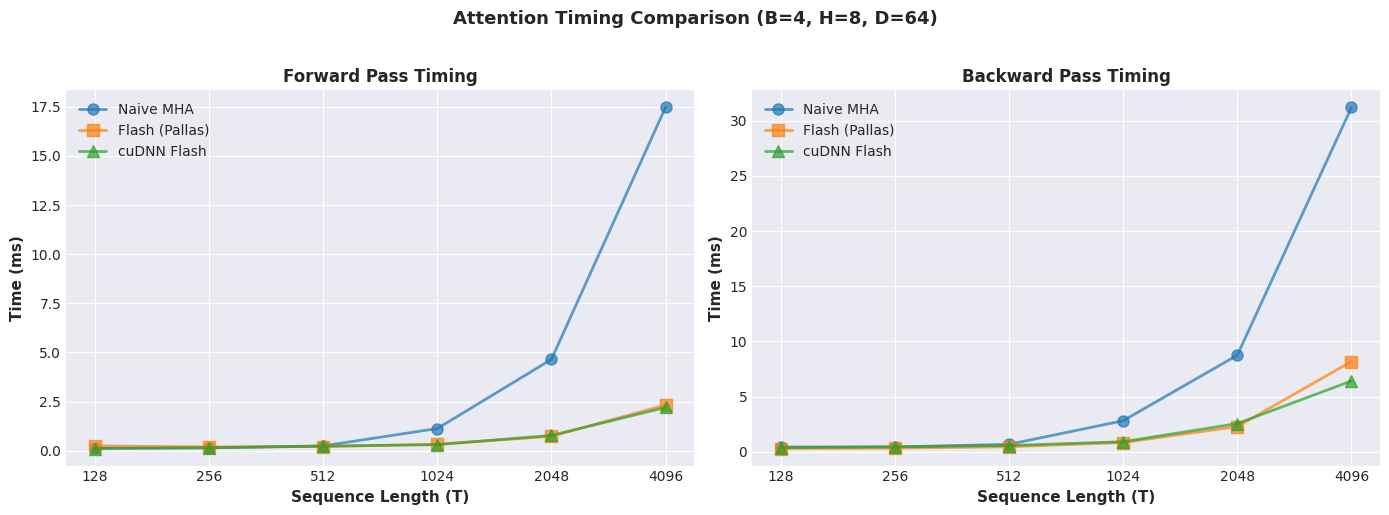

In [37]:
# Timing comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


seq_lengths = results["sequence_lengths"]
naive_fwd_times = [r["time_ms"] for r in results["naive"]["fwd"]]
flash_fwd_times = [r["time_ms"] for r in results["flash"]["fwd"]]
cudnn_fwd_times = [r["time_ms"] for r in results["cudnn"]["fwd"]]

naive_bwd_times = [r["time_ms"] for r in results["naive"]["bwd"]]
flash_bwd_times = [r["time_ms"] for r in results["flash"]["bwd"]]
cudnn_bwd_times = [r["time_ms"] for r in results["cudnn"]["bwd"]]

# Forward pass plot
axes[0].plot(seq_lengths, naive_fwd_times, 'o-',linewidth=2, markersize=8, label='Naive MHA', alpha=0.7)
axes[0].plot(seq_lengths, flash_fwd_times, 's-',linewidth=2, markersize=8, label='Flash (Pallas)', alpha=0.7)
axes[0].plot(seq_lengths, cudnn_fwd_times, '^-',linewidth=2, markersize=8, label='cuDNN Flash', alpha=0.7)
axes[0].set_xlabel('Sequence Length (T)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=11, fontweight='bold')
axes[0].set_title('Forward Pass Timing', fontsize=12, fontweight='bold')
axes[0].set_xscale('log', base=2)
#axes[0].set_yscale('log')
axes[0].set_xticks(seq_lengths)
axes[0].set_xticklabels([str(t) for t in seq_lengths])
#axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper left', fontsize=10)

# Backward pass plot
axes[1].plot(seq_lengths, naive_bwd_times, 'o-', linewidth=2, markersize=8, label='Naive MHA', alpha=0.7)
axes[1].plot(seq_lengths, flash_bwd_times, 's-', linewidth=2, markersize=8, label='Flash (Pallas)', alpha=0.7)
axes[1].plot(seq_lengths, cudnn_bwd_times, '^-', linewidth=2, markersize=8, label='cuDNN Flash', alpha=0.7)
axes[1].set_xlabel('Sequence Length (T)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Time (ms)', fontsize=11, fontweight='bold')
axes[1].set_title('Backward Pass Timing', fontsize=12, fontweight='bold')
axes[1].set_xscale('log', base=2)
#axes[1].set_yscale('log')
axes[1].set_xticks(seq_lengths)
axes[1].set_xticklabels([str(t) for t in seq_lengths])
#axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper left', fontsize=10)

plt.suptitle(f'Attention Timing Comparison (B={B}, H={H}, D={D})', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Key observations:**
- **Forward pass**: Our Pallas implementation matches cuDNN in wall-clock time at large sequence lengths (T≥1024), with both completing in ~2.2-2.3ms at T=4096
- **Backward pass**: cuDNN is faster in wall-clock time (6.4ms vs 8.2ms at T=4096), despite our implementation showing higher GFLOP/s. This is because our backward pass does more total FLOPs due to recomputing attention twice (see FLOP calculations below)
- **Massive speedup over naive**: Both flash implementations are 4-5x faster than naive attention at long sequences, which is the key benefit

**Important**: Wall-clock time is the true measure of performance. GFLOP/s measures hardware utilization, not algorithm efficiency—an algorithm doing more unnecessary work can show higher GFLOP/s while being slower overall.

## Roofline Analysis: Understanding Performance Bottlenecks

The roofline model is a visual framework for understanding whether a kernel is **compute-bound** or **memory-bound**. It helps explain why flash attention significantly outperforms naive attention despite doing the same mathematical computation.

**Important caveat**: The roofline model is useful for diagnosing bottlenecks *within a single algorithm*, but it should not be used to compare algorithms with different FLOP counts. An algorithm that does more work can achieve higher GFLOP/s while taking longer to complete. Wall-clock time is the only true measure of end-to-end performance.

### The Roofline Model

The roofline model plots **Arithmetic Intensity (AI)** on the x-axis against **Performance (GFLOP/s)** on the y-axis:

- **Arithmetic Intensity (AI)** = FLOPs / Bytes transferred
  - Measures how much computation you do per byte of data moved
  - Higher AI means the kernel reuses data more efficiently
  
- **Performance** = Achieved GFLOP/s
  - How fast the kernel actually runs

The "roofline" consists of two lines:
1. **Memory Roof** (diagonal): `Performance = Bandwidth × AI`
   - When AI is low, performance is limited by how fast you can move data
2. **Compute Roof** (horizontal): `Performance = Peak TFLOP/s`
   - When AI is high, performance is limited by how fast you can compute

The intersection is called the **ridge point**:
$$\text{Ridge AI} = \frac{\text{Peak Compute (FLOP/s)}}{\text{Peak Bandwidth (Bytes/s)}}$$

Kernels with AI below the ridge are memory-bound; above the ridge are compute-bound.

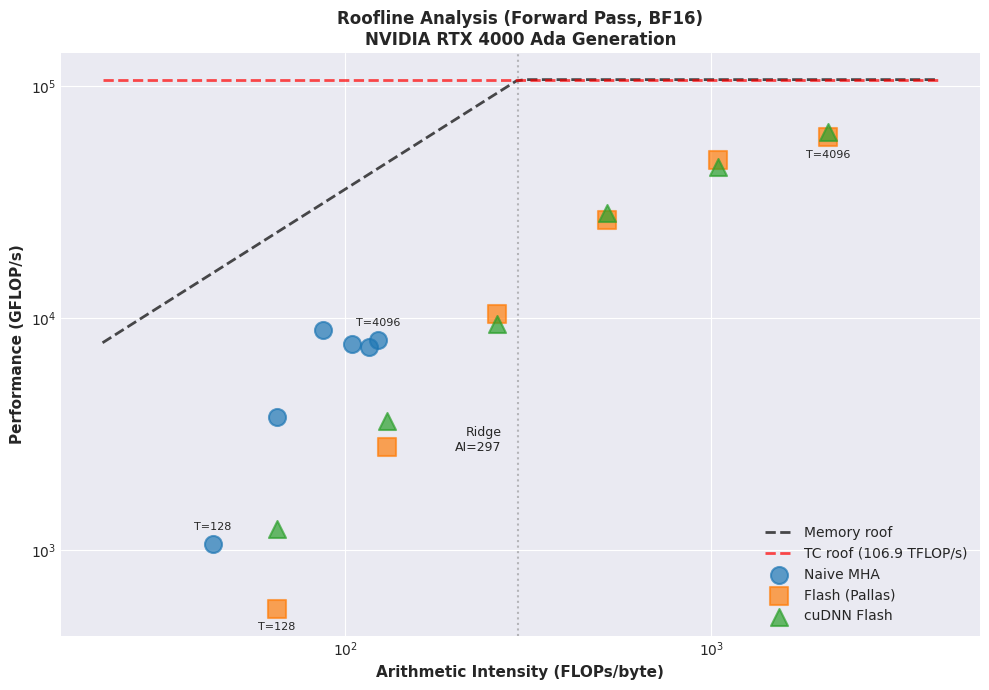

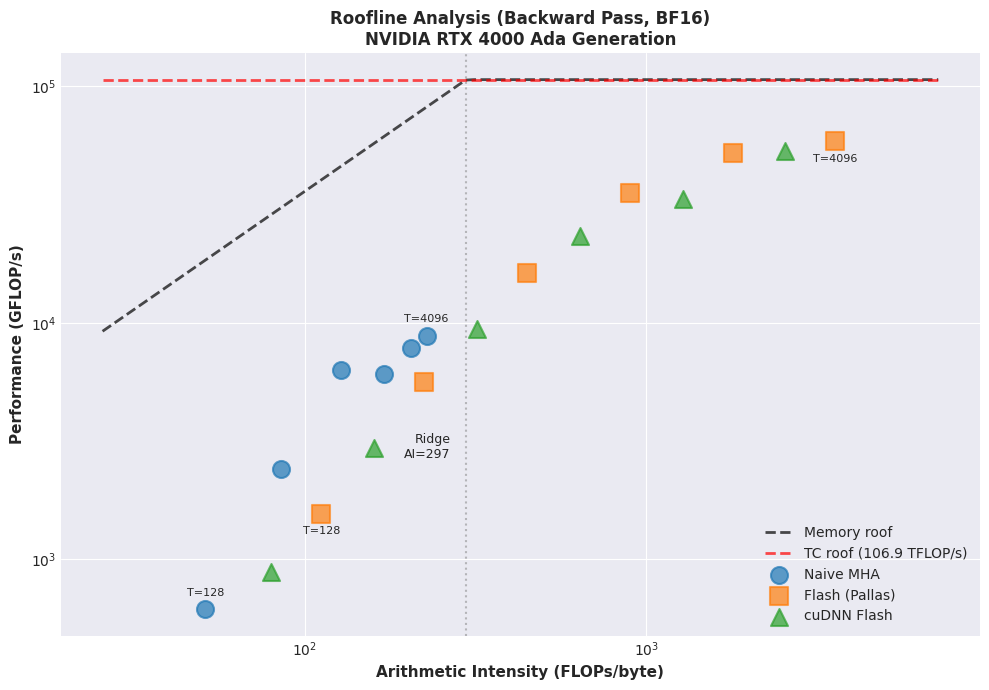

In [38]:
def generate_roofline_plot(results, pass_type="fwd"):
    """Generate roofline plot for forward or backward pass."""
    gpu = GPU_SPECS
    pass_name = "Forward" if pass_type == "fwd" else "Backward"
    ridge_ai = gpu["peak_compute_tflops_tc"] * 1000 / gpu["peak_bandwidth_gb_s"]
    
    seq_lengths = np.array(results["sequence_lengths"])
    naive_ai = np.array([r["ai"] for r in results["naive"][pass_type]])
    flash_ai = np.array([r["ai"] for r in results["flash"][pass_type]])
    cudnn_ai = np.array([r["ai"] for r in results["cudnn"][pass_type]])
    naive_perf = np.array([r["gflops_s"] for r in results["naive"][pass_type]])
    flash_perf = np.array([r["gflops_s"] for r in results["flash"][pass_type]])
    cudnn_perf = np.array([r["gflops_s"] for r in results["cudnn"][pass_type]])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    all_ai = np.concatenate([naive_ai, flash_ai, cudnn_ai])
    ai_min, ai_max = min(all_ai.min(), ridge_ai) / 2, max(all_ai.max(), ridge_ai) * 2
    ai_range = np.logspace(np.log10(ai_min), np.log10(ai_max), 100)
    
    memory_roof = gpu["peak_bandwidth_gb_s"] * ai_range
    compute_roof = gpu["peak_compute_tflops_tc"] * 1000 * np.ones_like(ai_range)
    memory_roof = np.minimum(memory_roof, compute_roof)
    
    ax.plot(ai_range, memory_roof, 'k--', lw=2, alpha=0.7, label='Memory roof')
    ax.plot(ai_range, compute_roof, 'r--', lw=2, alpha=0.7, label=f'TC roof ({gpu["peak_compute_tflops_tc"]:.1f} TFLOP/s)')
    
    ax.scatter(naive_ai, naive_perf, marker='o', s=150, lw=1.5, label='Naive MHA', zorder=5, alpha=0.7)
    ax.scatter(flash_ai, flash_perf, marker='s', s=150, lw=1.5, label='Flash (Pallas)', zorder=5, alpha=0.7)
    ax.scatter(cudnn_ai, cudnn_perf, marker='^', s=150, lw=1.5, label='cuDNN Flash', zorder=5, alpha=0.7)
    
    for i, T in enumerate(seq_lengths):
        if i == 0 or i == len(seq_lengths) - 1:
            ax.annotate(f'T={T}', (naive_ai[i], naive_perf[i]), fontsize=8, xytext=(0, 10), textcoords='offset points', ha='center')
            ax.annotate(f'T={T}', (flash_ai[i], flash_perf[i]), fontsize=8, xytext=(0, -15), textcoords='offset points', ha='center')
    
    ax.axvline(ridge_ai, color='gray', ls=':', alpha=0.5)
    ax.text(ridge_ai * 0.9, gpu["peak_compute_tflops"] * 100, f'Ridge\nAI={ridge_ai:.0f}', fontsize=9, ha='right')
    
    ax.set_xlabel('Arithmetic Intensity (FLOPs/byte)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Performance (GFLOP/s)', fontsize=11, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Roofline Analysis ({pass_name} Pass, BF16)\n{gpu["name"]}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    return fig

# Generate roofline plots
fig_fwd = generate_roofline_plot(results, "fwd")
fig_bwd = generate_roofline_plot(results, "bwd")
plt.show()

The key insight from the roofline analysis is that flash attention moves both implementations from the memory-bound regime (low AI) to the compute-bound regime (high AI). This explains the dramatic speedup over naive attention. Note that our Pallas implementation shows higher GFLOP/s than cuDNN in the backward pass, but this reflects our higher FLOP count (recomputing attention twice) rather than better performance—cuDNN is faster in wall-clock time.

## Limitations and Future Work

### Performance Achievement

Our Pallas implementation achieves performance **competitive with NVIDIA's cuDNN flash attention**:

- **Forward pass**: Within 5% of cuDNN wall-clock time at large sequence lengths (T≥1024)
- **Backward pass**: ~25% slower than cuDNN (8.2ms vs 6.4ms at T=4096), due to our three-kernel design requiring two attention recomputations

This was achieved through careful mixed-precision optimization (see the Precision Optimization section above).

### Remaining Gaps

1. **Small sequence lengths**: At T<512, kernel launch overhead dominates and naive attention can be faster. Production implementations often fall back to naive attention for short sequences.

2. **Backward pass efficiency**: Our three-kernel approach recomputes attention twice (once for dK/dV, once for dQ), adding ~40% more FLOPs compared to cuDNN's fused approach.

3. **No causal masking optimization**: Causal attention can skip computation for masked positions, but our implementation computes the full attention matrix.

### Pallas Limitations

Pallas provides a high-level abstraction for writing GPU kernels, but it doesn't expose certain low-level primitives:

- **No warp-level programming**: Pallas doesn't provide access to `warp_id` or warp shuffle operations. You can configure `num_warps` but cannot coordinate work between warps within a block.

- **Limited shared memory control**: Pallas manages shared memory implicitly through `BlockSpec`. You cannot explicitly allocate shared memory or control synchronization barriers.

- **No atomic operations**: Pallas on GPU doesn't expose `atomic_add`, requiring separate kernels for reductions (like our three-kernel backward pass).

### Path to Further Improvement

1. **Autotuning block sizes**: Our fixed BLOCK_R=BLOCK_C=64 may not be optimal for all configurations. Dynamic tuning could help.

2. **Fusing backward kernels**: The three-kernel approach adds overhead. With careful synchronization, these could potentially be fused.

3. **Causal masking**: Skip computation for masked positions in the attention matrix.

### Educational Value

Despite targeting production-level performance, this implementation retains significant educational value:

- **Algorithm clarity**: The tiled computation with online softmax correction is clearly visible in the code
- **Gradient derivation**: The backward pass shows exactly how gradients flow through attention
- **Precision analysis**: The mixed-precision strategy demonstrates real-world optimization thinking
- **Debugging**: `INTERPRET_MODE=True` allows stepping through the algorithm on CPU

## References

1. Dao, T., Fu, D., Ermon, S., Rudra, A., & Re, C. (2022). FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness. *NeurIPS 2022*. https://arxiv.org/abs/2205.14135
2. Dao, T. (2023). FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning. *arXiv preprint arXiv:2307.08691*. https://arxiv.org/abs/2307.08691
3. JAX Official Flash Attention (TPU): https://github.com/jax-ml/jax/blob/main/jax/experimental/pallas/ops/tpu/flash_attention.py
4. JAX Official Fused Attention (GPU): https://github.com/jax-ml/jax/blob/main/jax/experimental/pallas/ops/gpu/attention.py
5. Umar Jamil's Triton Flash Attention: https://github.com/hkproj/triton-flash-attention
6. Sebastian Raschka - Understanding and Coding Self-Attention from Scratch: https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html
7. https://docs.nvidia.com/cuda/ada-tuning-guide/index.html